# Playing with MNIST

This notebook expects you to have previously trained the MNIST model and saved the resulting file. You should also make sure that you have the latest version of `canvas.py` file and the necessary images in the same directory as this notebook. 
You can download all the necessary files by executing this:

```bash
!curl -O https://raw.githubusercontent.com/colormotor/DMLAP/main/python/canvas.py
!curl -O https://raw.githubusercontent.com/colormotor/DMLAP/main/python/images.zip
!unzip -o images.zip
```

## Note for Google Colab users:
For this notebook to work in Google Colab you will need to execute the following code cell when starting up a new session:

```bash
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
```

You will then need to either manually upload the model file, or setup your notebook to mount a Google drive. 

For the latter option, you need to mount your drive to the machine, like so:

```python
from google.colab import drive
drive.mount('/content/drive')

# change directory using the os module
import os
os.chdir('drive/My Drive/')
os.listdir() # shows the contents of the current dir, you can use chdir again after that
```

See [this notebook](https://colab.research.google.com/notebooks/io.ipynb), and [Working With Files](https://realpython.com/working-with-files-in-python/) on Real Python.

In [1]:
import canvas
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

## Load a trained network

In [6]:
model = tf.keras.models.load_model('./models/dense_mnist.keras')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 435402 (1.66 MB)
Trainable params: 435402 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Classify an image of a number

Shape of x before processing: (28, 28, 1), dtype: float32


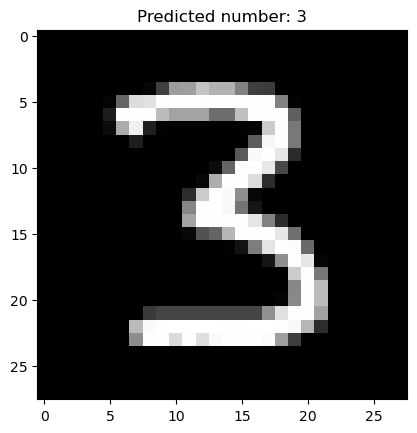

In [7]:
                       # try 4.png
img = image.load_img('images/number3.png', target_size=(28, 28), color_mode='grayscale')

# convert pixel values from [0,255] to [0,1]
x = image.img_to_array(img) / 255

print(f"Shape of x before processing: {x.shape}, dtype: {x.dtype}")

# For a Dense net, we need (batch_size, 28*28=784)
x = x.reshape(1, -1) # '-1' meaning "deduce the last dim", same as x.reshape(1, 28*28)

# For a ConvNet, we need a shape of (batch_size, w, h, channels)
# x = np.expand_dims(x, 0) # add a batch dim at the front, same as x[None, ...]

predictions = model.predict(x, verbose=False)
predicted = np.argmax(predictions[0])
canvas.show_image(img, title=f'Predicted number: {predicted}', cmap='gray')

## Two directions

1. **disrupt**: try and find cases where the network fails to predict the images properly
2. **generate**: come up with your own images and try to classify them! Combining the two, you can try to generate images that the network fails to classify!

### Note: Dense vs ConvNet

If you tried to train a ConvNet, you will notice that it tends to be more stable in its prediction!

## 1. Disrupt

Here we provide you with a canvas object that generates images with a number. You can see that a Dense net not always succeeds (and the ConvNet does).

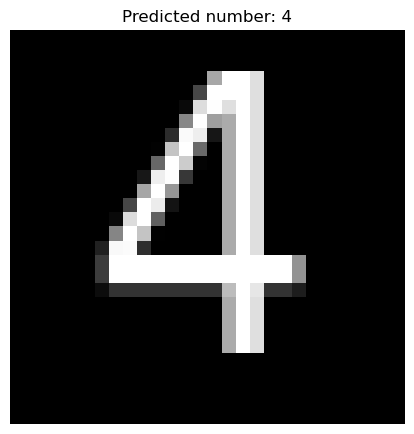

In [24]:
# Generate a random number between 0 and 9 (the max is excluded)
number = np.random.randint(0, 10) 
c = canvas.Canvas(28, 28)
c.background(0)
c.fill(255)
c.text_size(26)
c.text([c.width/2, c.height/2 + 9], str(number), center=True)
x = c.get_image_grayscale()

# For a Dense net
x = x.reshape(1, -1) # same as reshape(1, 28*28)

# # For a ConvNet:
# x = x.reshape(1, 28, 28, 1) # batch, w, h, channels

predictions = model.predict(x, verbose=False)
# Get the index in the array with highest confidence, that will be our predicted number
predicted = np.argmax(predictions[0])
c.show(title=f'Predicted number: {predicted}', size=(512, 512))

Disruption, first idea: how about we invert the colours? We do that by adding: `1.0 - c.get_image_grayscale()` (our pixel values lie between 0 and 1.

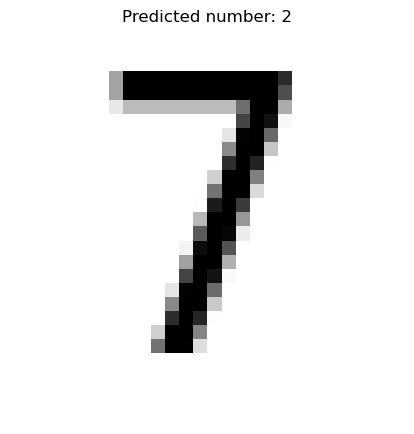

In [36]:
number = np.random.randint(0, 10)
c = canvas.Canvas(28, 28)
c.background(255)
c.fill(0)
c.text_size(26)
c.text([c.width/2, c.height/2 + 9], str(number), center=True)
x = 1.0 - c.get_image_grayscale() # Inverted (note: this array has already values in [0,1], no need to divide by 255)

# For a Dense net
x = x.reshape(1, -1) # same as reshape(1, 28*28)

# # For a ConvNet:
# x = x.reshape(1, 28, 28, 1) # batch, w, h, channels

predictions = model.predict(x, verbose=False)
# Get the index in the array with highest confidence, that will be our predicted number
predicted = np.argmax(predictions[0])
c.show(title=f'Predicted number: {predicted}', size=(512, 512))

### Ideas for exploration

- Creatively disrupt the image, keeping it recognizable to a human, but causing the model to produce an incorrect prediction. You could add random dots, or patches, for instance. Or simply create an array of random numbers of the same size as the image and add it to the image.
- Try to do this in steps, e.g. incrementally adding modifications to the image and observing when and how it stops being recongized by the model.
- Briefly discuss the steps you are taking, taking advantage of the hybrid markdown/code format of the notebook.

Make sure to display the images you are creaating!

You may want to work with the `Canvas` object directly, using some tools demonstrated in the relevant notebook, in which case you should keep in mind that you are only producing grayscale images and that the images have size 28x28.

Otherwise you might as well work by preparing images externally (e.g. by hand, or using p5js) and then loading these as we have seen earlier for the image of a four. If you take this approach, make sure you start from an image that is consistently recognizable to a human as a given number and correctly classified by the model as that same number.

## 2. Generate

Here is a simple example that looks like a `0`, and usually gets classified as one.

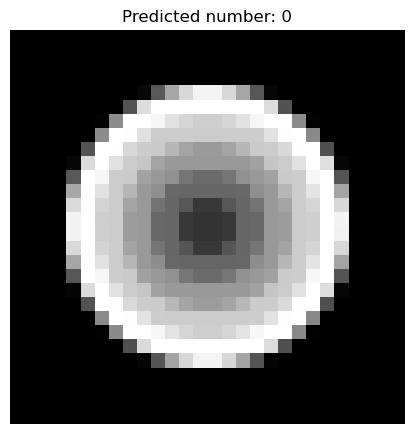

In [48]:
c = canvas.Canvas(28, 28)
c.background(0)

c.no_stroke()
for t in np.linspace(1, 0.2, 5):
    c.fill(255*t)
    c.circle([c.width/2, c.height/2], 10*t)

x = c.get_image_grayscale()

# For a Dense net
x = x.reshape(1, -1) # same as reshape(1, 28*28)

# # For a ConvNet:
# x = x.reshape(1, 28, 28, 1) # batch, w, h, channels

predictions = model.predict(x, verbose=False)
# Get the index in the array with highest confidence, that will be our predicted number
predicted = np.argmax(predictions[0])
c.show(title=f'Predicted number: {predicted}', size=(512, 512))

This most interesting when not using the text function any more, but rather using the drawing abilities of canvas.

Try different numbers!

**Also**, try shapes that *really do not look like numbers* to us, and see what happens.

As before, a ConvNet will probably perform better than a plain Dense net.

### Note

If you trained a net on FashionMNIST, you can do the same thing but with pieces of clothing! (The images must always be b&w, 28*28!).

## Note for submissions

If you want to experiment with this notebook and submit it for your weekly assignment, please create a new folder that can be run out of the box, so including `canvas.py` and your model.

The folder structure should look like the following:
```bash
name002_mnist/
├── canvas.py
├── data/
│   ├── 7.png
│   ├── disruption.png
│   └── ... # more data
├── models/
│   └── basic_mnist.keras
└── notebook.ipynb
```
    
In addition, if you generate images with p5js, make sure you also provide the relevant sketches.